In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

In [4]:
df = pd.read_csv(
    "/content/drive/MyDrive/Powercast AI/household_power_consumption.txt",
    sep=';',
    low_memory=False
)

In [5]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [7]:
df.describe()

,Sub_metering_3
count,2.049280e+06
mean,6.458447e+00
std,8.437154e+00
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.700000e+01
max,3.100000e+01


In [8]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.set_index('Datetime', inplace=True)

/tmp/ipython-input-1005024584.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


In [9]:
df['Global_active_power'] = pd.to_numeric(
    df['Global_active_power'],
    errors='coerce'
)

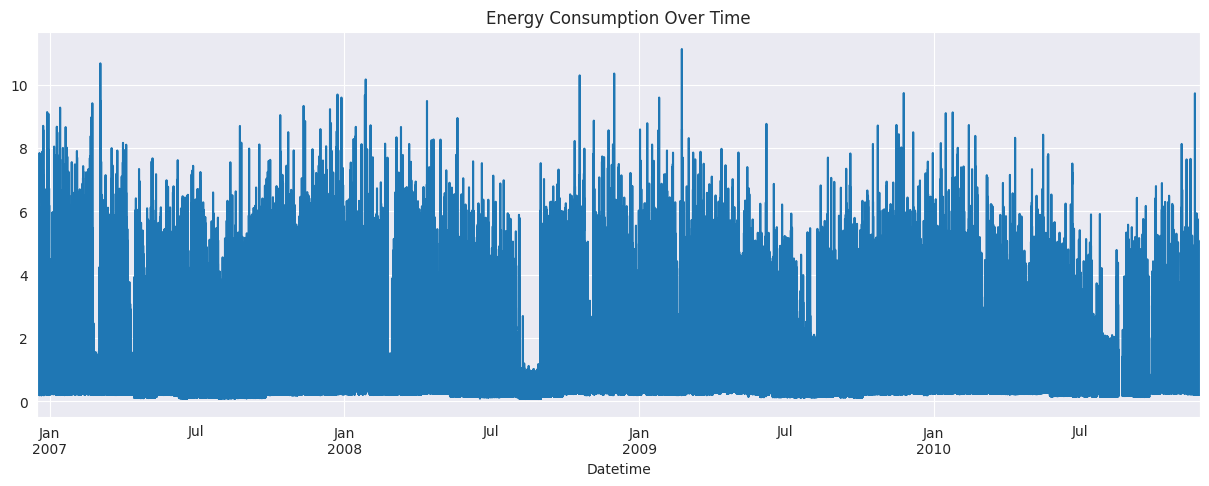

In [10]:
plt.figure(figsize=(15,5))
df['Global_active_power'].plot()
plt.title("Energy Consumption Over Time")
plt.show()

<Axes: xlabel='Datetime'>

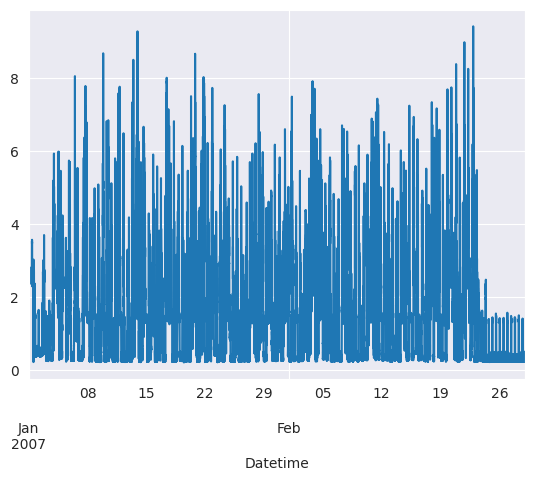

In [11]:
df['Global_active_power']['2007-01':'2007-02'].plot()

In [12]:
df.isna().sum()

,0
Date,0
Time,0
Global_active_power,25979
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,25979


## Initial Observations

- The dataset contains household energy consumption measurements recorded over time.
- The Date and Time columns were combined into a Datetime index.
- The Global_active_power column was converted to numeric format.
- Initial visualization shows fluctuations in energy usage over time.
- Missing values are present and will be handled in the next phase.

In [13]:
missing_percentage = df['Global_active_power'].isna().mean() * 100
print(f"Missing Percentage: {missing_percentage:.2f}%")

Missing Percentage: 1.25%


In [14]:
df['Global_active_power'].fillna(method='ffill', inplace=True)

/tmp/ipython-input-2757199224.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Global_active_power'].fillna(method='ffill', inplace=True)


In [15]:
df['Global_active_power'].isna().sum()

np.int64(0)

## Missing Value Handling

Missing values were handled using forward fill (ffill), which propagates the last valid observation forward.
This method is suitable for time-series data where consecutive values are correlated.

In [16]:
daily_df = df['Global_active_power'].resample('D').mean()

In [17]:
daily_df.head()

,Global_active_power
Datetime,
2006-12-16,3.053475
2006-12-17,2.354486
2006-12-18,1.530435
2006-12-19,1.157079
2006-12-20,1.545658


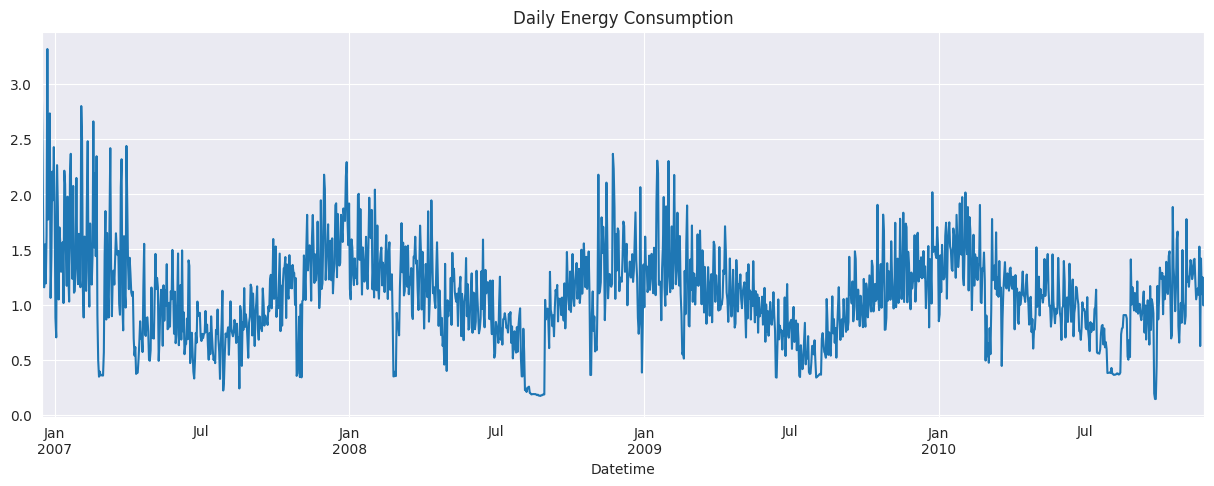

In [18]:
plt.figure(figsize=(15,5))
daily_df.plot()
plt.title("Daily Energy Consumption")
plt.show()

## Daily Resampling

The dataset was resampled to daily averages to:
- Reduce noise
- Improve computational efficiency
- Capture broader consumption patterns

/tmp/ipython-input-3092249425.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = daily_df.resample('M').mean()


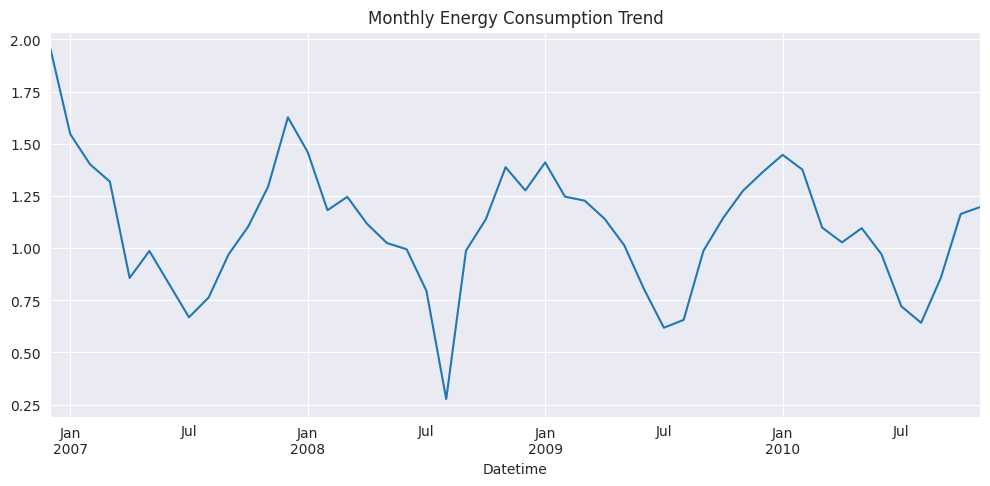

In [19]:
monthly_df = daily_df.resample('M').mean()

plt.figure(figsize=(12,5))
monthly_df.plot()
plt.title("Monthly Energy Consumption Trend")
plt.show()

## Monthly Trend Analysis

Monthly aggregation helps identify seasonality and long-term trends in energy consumption.

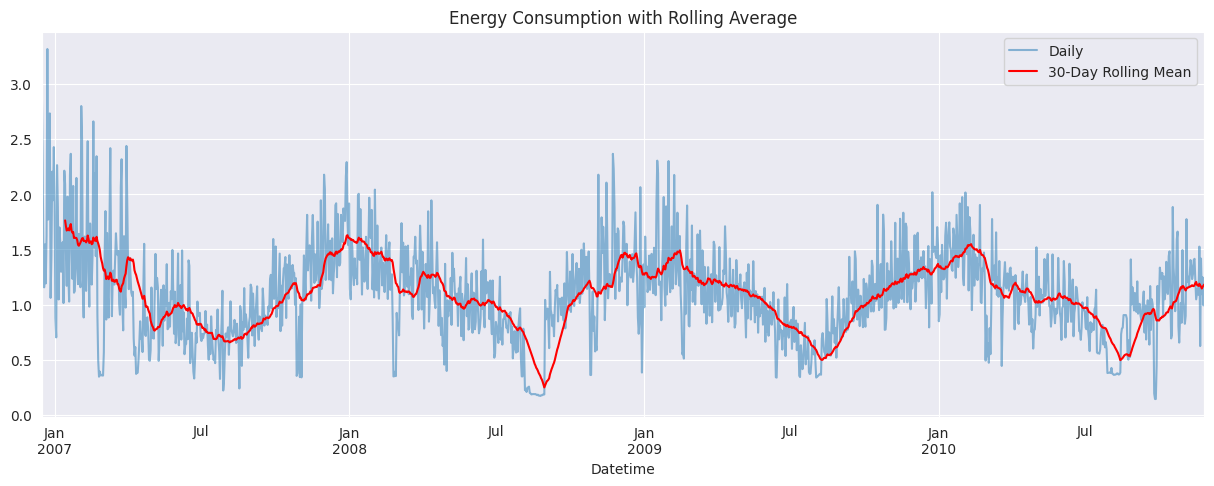

In [20]:
rolling_mean = daily_df.rolling(window=30).mean()

plt.figure(figsize=(15,5))
daily_df.plot(alpha=0.5, label='Daily')
rolling_mean.plot(color='red', label='30-Day Rolling Mean')
plt.legend()
plt.title("Energy Consumption with Rolling Average")
plt.show()

## Trend Smoothing

A 30-day rolling mean was applied to smooth short-term fluctuations and highlight long-term trends.

In [21]:
train = daily_df[:-30]
test = daily_df[-30:]

In [22]:
print(len(train), len(test))

1412 30


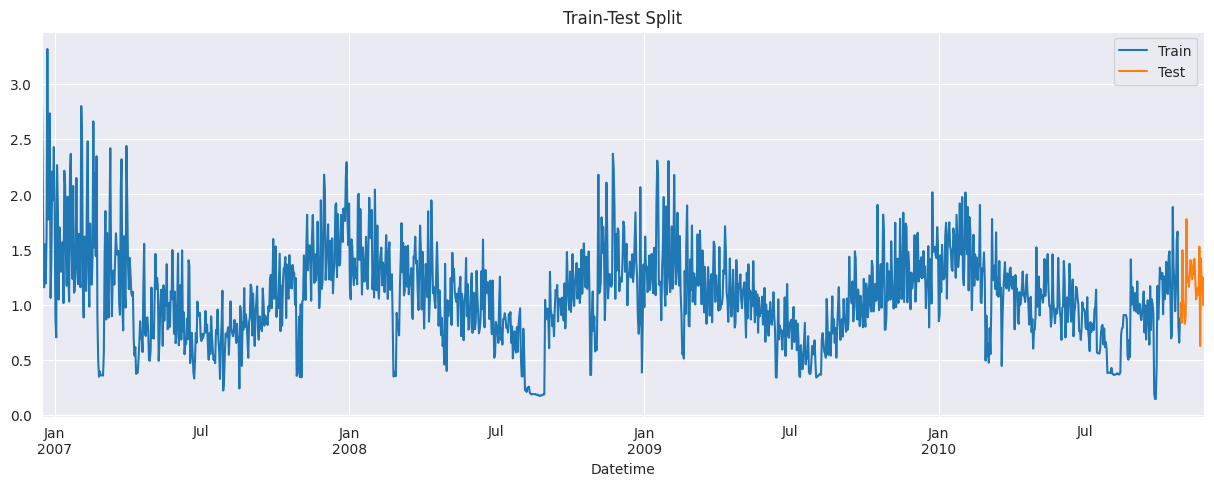

In [23]:
plt.figure(figsize=(15,5))
train.plot(label='Train')
test.plot(label='Test')
plt.legend()
plt.title("Train-Test Split")
plt.show()

## Train-Test Split

The last 30 days of data were reserved as test data to evaluate forecasting performance.

In [24]:
prophet_df = daily_df.reset_index()
prophet_df.columns = ['ds', 'y']
prophet_df.head()

,ds,y
0,2006-12-16,3.053475
1,2006-12-17,2.354486
2,2006-12-18,1.530435
3,2006-12-19,1.157079
4,2006-12-20,1.545658


## Prophet Data Preparation

The dataset was reformatted to match Prophet's required structure:
- ds → Date column
- y → Target variable (energy consumption)

## Observations from Trend Analysis

- The data shows fluctuations in daily energy usage.
- Monthly aggregation indicates potential seasonal patterns.
- Rolling mean highlights long-term consumption trends.
- The dataset is now clean and structured for forecasting models.

In [25]:
!pip install prophet

In [26]:
from prophet import Prophet

In [27]:
train_prophet = prophet_df[:-30]
test_prophet = prophet_df[-30:]

In [28]:
train_prophet.head()

,ds,y
0,2006-12-16,3.053475
1,2006-12-17,2.354486
2,2006-12-18,1.530435
3,2006-12-19,1.157079
4,2006-12-20,1.545658


## Prophet Training Data

The dataset was split into:
- Training set: All data except last 30 days
- Test set: Last 30 days (used for evaluation)

In [29]:
model = Prophet()
model.fit(train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Model Training

A Prophet model was initialized and trained on historical daily energy consumption data.

In [30]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

In [31]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2006-12-16,1.234106,1.337057,2.105615,1.234106,1.234106,0.496987,0.496987,0.496987,0.147631,0.147631,0.147631,0.349356,0.349356,0.349356,0.0,0.0,0.0,1.731093
1,2006-12-17,1.233183,1.308264,2.110964,1.233183,1.233183,0.478325,0.478325,0.478325,0.120569,0.120569,0.120569,0.357755,0.357755,0.357755,0.0,0.0,0.0,1.711508
2,2006-12-18,1.232260,1.105774,1.849473,1.232260,1.232260,0.269661,0.269661,0.269661,-0.096781,-0.096781,-0.096781,0.366441,0.366441,0.366441,0.0,0.0,0.0,1.501920
3,2006-12-19,1.231337,1.197889,2.007004,1.231337,1.231337,0.356745,0.356745,0.356745,-0.018393,-0.018393,-0.018393,0.375138,0.375138,0.375138,0.0,0.0,0.0,1.588081
4,2006-12-20,1.230413,1.259131,1.982673,1.230413,1.230413,0.382332,0.382332,0.382332,-0.001233,-0.001233,-0.001233,0.383565,0.383565,0.383565,0.0,0.0,0.0,1.612745


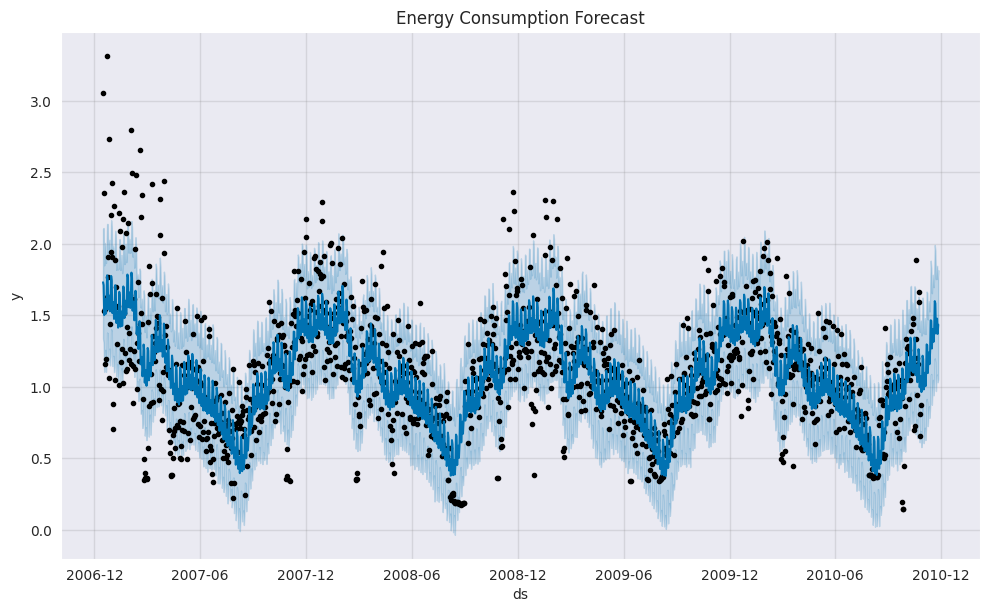

In [32]:
fig1 = model.plot(forecast)
plt.title("Energy Consumption Forecast")
plt.show()

## Forecast Visualization

The forecast plot displays predicted energy consumption along with uncertainty intervals.

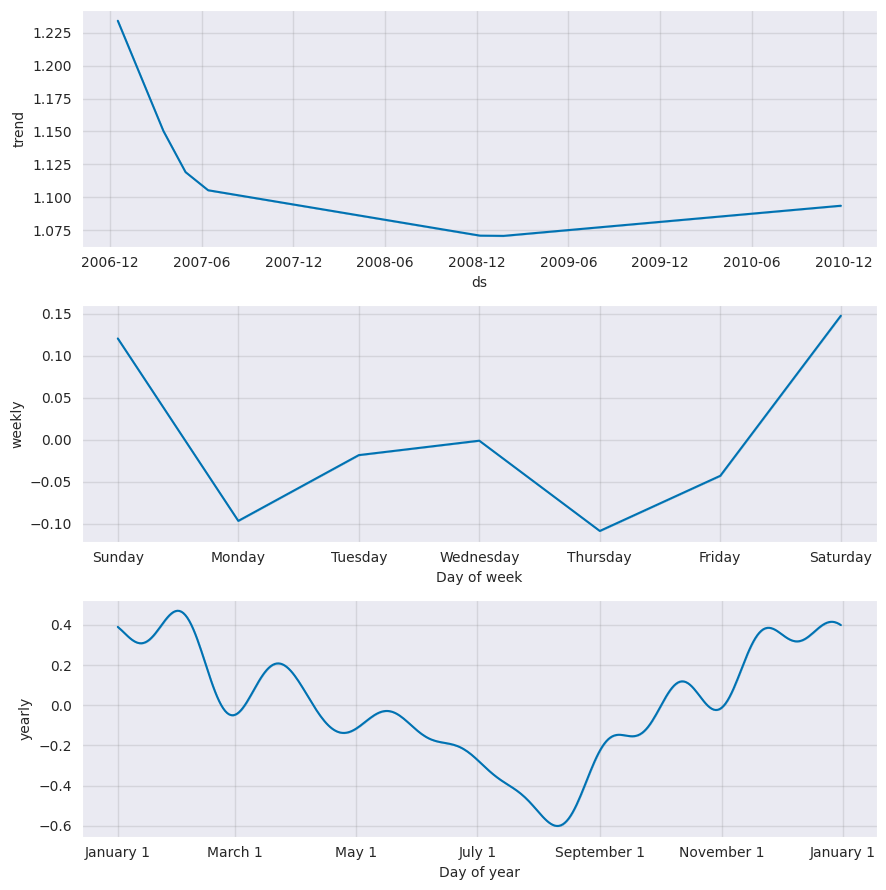

In [33]:
fig2 = model.plot_components(forecast)
plt.show()

In [34]:
forecast_test = forecast[['ds', 'yhat']].tail(30)

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

actual = test_prophet['y'].values
predicted = forecast_test['yhat'].values

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.21188738905201404
RMSE: 0.2942602461802632


## Model Evaluation

- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)

These metrics evaluate how close predictions are to actual energy consumption values.